# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

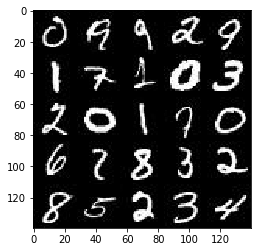

In [2]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

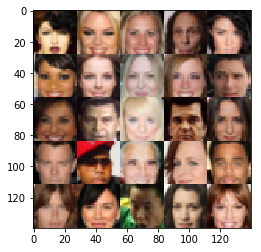

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function

    input_real = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels) , name = 'input_real')
    input_z = tf.placeholder(tf.float32, (None, z_dim), name = 'input_z')
    learning_rate = tf.placeholder(tf.float32, [], name = 'learning_rate')
    
    
    return input_real, input_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Leaky ReLU

In [6]:
def leaky_relu(x, alpha=0.05, name='leaky_relu'): 
    return tf.maximum(alpha * x, x, name=name)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [14]:
def discriminator(images, reuse=False, alpha = 0.2, rate = 0.1):
    """
    Create the discriminator network
    :param image: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    with tf.variable_scope('discriminator', reuse = reuse):
        #input 28x28x3        
        images = tf.layers.conv2d(images, 128, 3, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())                
        images = leaky_relu(images, alpha = alpha)
        images = tf.layers.dropout(images, rate, training= True)
        # 14x14x128
        
        images = tf.layers.conv2d(images, 256, 3, strides = 2, padding = 'same', use_bias=False, kernel_initializer = tf.contrib.layers.xavier_initializer())
        images = tf.layers.batch_normalization(images, training = True)
        images = leaky_relu(images, alpha = alpha)
        images = tf.layers.dropout(images, rate, training= True)
        #7x7x256
        
        images = tf.layers.conv2d(images, 512, 3, strides = 2, padding = 'same', use_bias=False, kernel_initializer = tf.contrib.layers.xavier_initializer())
        images = tf.layers.batch_normalization(images, training = True)
        images = leaky_relu(images, alpha = alpha)
        images = tf.layers.dropout(images, rate, training= True)
        #4x4x512
        
        #flatted
        flat = tf.reshape(images, (-1, 4 * 4 * 512))
        logits = tf.layers.dense(flat, 1, )
        out = tf.sigmoid(logits)
    
    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variabes in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2, rate = 0.1):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse = not is_train):
        x = tf.layers.dense(z, 7 * 7 * 512,  use_bias=False, kernel_initializer = tf.contrib.layers.xavier_initializer())
        x = tf.reshape(x, (-1, 7, 7, 512))
        x = tf.layers.batch_normalization(x, training = is_train)
        x = leaky_relu(x, alpha = alpha)   
        x = tf.layers.dropout(x, rate, training= is_train)
        # 7x7x512
        
        x = tf.layers.conv2d_transpose(x, 256, 5, strides = 1, padding = 'same', use_bias=False, kernel_initializer = tf.contrib.layers.xavier_initializer())       
        x = tf.layers.batch_normalization(x, training = is_train)
        x = leaky_relu(x, alpha = alpha)
        x = tf.layers.dropout(x, rate, training= is_train)
        # 7x7x256
        
        x = tf.layers.conv2d_transpose(x, 128, 5, strides = 2, padding = 'same', use_bias=False, kernel_initializer = tf.contrib.layers.xavier_initializer())       
        x = tf.layers.batch_normalization(x, training = is_train)
        x = leaky_relu(x, alpha = alpha)
        x = tf.layers.dropout(x, rate, training= is_train)
        # 14x14x128
        
        logits = tf.layers.conv2d_transpose(x, out_channel_dim, 5, strides = 2, padding = 'same', kernel_initializer = tf.contrib.layers.xavier_initializer())
        # 28, 28, out_channel_dim
        
        out = tf.tanh(logits)
    
    
    return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim, smooth = 0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True)
    d_model_real, d_logits_real = discriminator(input_real, reuse = False)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse = True)
        

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.random_uniform(tf.shape(d_model_real), 0.7, 1.2, tf.float32)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.random_uniform(tf.shape(d_logits_fake), 0, 0.3, tf.float32)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))


    d_loss = d_loss_real + d_loss_fake
    
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [12]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode, 
          print_every=10, show_every=50):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
        
    # TODO: Build Model      
    
    input_real, input_z, lr = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, lr, beta1)
    
    steps = 0
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):            
            for batch_images in get_batches(batch_size):
                # TODO: Train Model                
                steps = steps + 1
                images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: images, input_z: batch_z, lr: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_real: images, input_z: batch_z, lr: learning_rate})
                                
                if steps % print_every == 0:
                   
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{}...".format(epoch_i + 1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))

                if steps % show_every == 0:                    
                    show_generator_output(sess, n_images = 16, 
                                          input_z = input_z, out_channel_dim = data_shape[3], image_mode = data_image_mode)

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 1/2... Discriminator Loss: 0.9048... Generator Loss: 1.4293
Epoch 1/2... Discriminator Loss: 0.8907... Generator Loss: 1.4096
Epoch 1/2... Discriminator Loss: 0.9661... Generator Loss: 1.2903
Epoch 1/2... Discriminator Loss: 0.8737... Generator Loss: 2.2724
Epoch 1/2... Discriminator Loss: 1.3895... Generator Loss: 0.5449


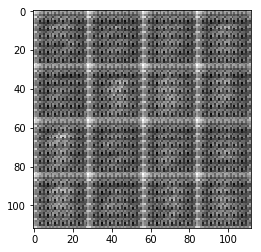

Epoch 1/2... Discriminator Loss: 1.3545... Generator Loss: 0.7373
Epoch 1/2... Discriminator Loss: 1.3025... Generator Loss: 1.0606
Epoch 1/2... Discriminator Loss: 1.2244... Generator Loss: 1.2276
Epoch 1/2... Discriminator Loss: 1.1810... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 1.0227... Generator Loss: 0.9137


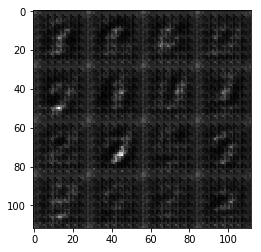

Epoch 1/2... Discriminator Loss: 1.0823... Generator Loss: 0.7456
Epoch 1/2... Discriminator Loss: 1.4213... Generator Loss: 0.5380
Epoch 1/2... Discriminator Loss: 1.3125... Generator Loss: 0.6887
Epoch 1/2... Discriminator Loss: 1.4333... Generator Loss: 0.5186
Epoch 1/2... Discriminator Loss: 1.3121... Generator Loss: 0.9300


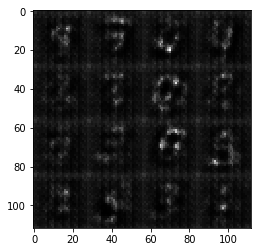

Epoch 1/2... Discriminator Loss: 1.0665... Generator Loss: 1.1984
Epoch 1/2... Discriminator Loss: 1.1928... Generator Loss: 0.6386
Epoch 1/2... Discriminator Loss: 1.3488... Generator Loss: 0.5662
Epoch 1/2... Discriminator Loss: 1.1950... Generator Loss: 1.0890
Epoch 1/2... Discriminator Loss: 1.1108... Generator Loss: 0.8386


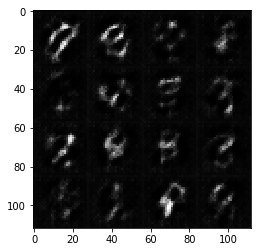

Epoch 1/2... Discriminator Loss: 1.1359... Generator Loss: 1.2843
Epoch 1/2... Discriminator Loss: 1.1298... Generator Loss: 0.6961
Epoch 1/2... Discriminator Loss: 1.1935... Generator Loss: 1.2538
Epoch 1/2... Discriminator Loss: 1.0792... Generator Loss: 1.0816
Epoch 1/2... Discriminator Loss: 1.3770... Generator Loss: 0.4272


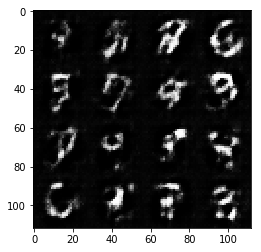

Epoch 1/2... Discriminator Loss: 1.1493... Generator Loss: 0.7355
Epoch 1/2... Discriminator Loss: 1.2979... Generator Loss: 0.5513
Epoch 1/2... Discriminator Loss: 1.1884... Generator Loss: 0.8228
Epoch 1/2... Discriminator Loss: 1.0579... Generator Loss: 0.9115
Epoch 1/2... Discriminator Loss: 1.0622... Generator Loss: 0.8652


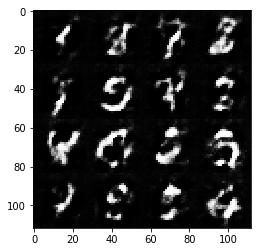

Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.8364
Epoch 1/2... Discriminator Loss: 1.0133... Generator Loss: 1.0906
Epoch 1/2... Discriminator Loss: 1.1366... Generator Loss: 1.0899
Epoch 1/2... Discriminator Loss: 1.0708... Generator Loss: 0.8973
Epoch 1/2... Discriminator Loss: 1.0065... Generator Loss: 0.8837


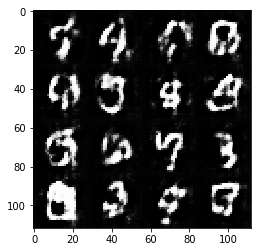

Epoch 1/2... Discriminator Loss: 1.1428... Generator Loss: 0.7979
Epoch 1/2... Discriminator Loss: 1.1542... Generator Loss: 0.6537
Epoch 1/2... Discriminator Loss: 1.2623... Generator Loss: 1.6560
Epoch 1/2... Discriminator Loss: 1.1038... Generator Loss: 0.6788
Epoch 1/2... Discriminator Loss: 1.1159... Generator Loss: 0.6345


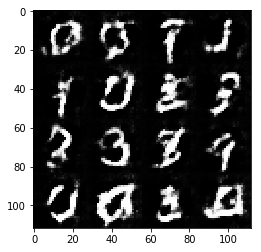

Epoch 1/2... Discriminator Loss: 1.0762... Generator Loss: 0.7516
Epoch 1/2... Discriminator Loss: 0.9569... Generator Loss: 0.9102
Epoch 1/2... Discriminator Loss: 1.2007... Generator Loss: 1.5063
Epoch 1/2... Discriminator Loss: 1.1720... Generator Loss: 0.7625
Epoch 1/2... Discriminator Loss: 1.2075... Generator Loss: 0.6122


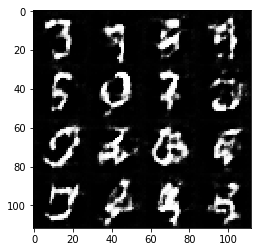

Epoch 1/2... Discriminator Loss: 1.1548... Generator Loss: 1.5305
Epoch 1/2... Discriminator Loss: 1.0361... Generator Loss: 1.0775
Epoch 1/2... Discriminator Loss: 1.3118... Generator Loss: 0.4751
Epoch 1/2... Discriminator Loss: 1.1562... Generator Loss: 0.5281
Epoch 1/2... Discriminator Loss: 1.2852... Generator Loss: 0.5664


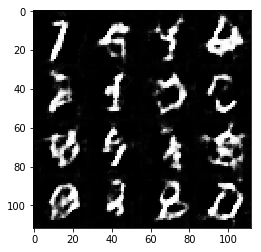

Epoch 1/2... Discriminator Loss: 1.0761... Generator Loss: 0.7991
Epoch 1/2... Discriminator Loss: 1.2214... Generator Loss: 1.3511
Epoch 1/2... Discriminator Loss: 1.2670... Generator Loss: 0.6376
Epoch 1/2... Discriminator Loss: 1.0758... Generator Loss: 0.9386
Epoch 1/2... Discriminator Loss: 1.1207... Generator Loss: 0.8247


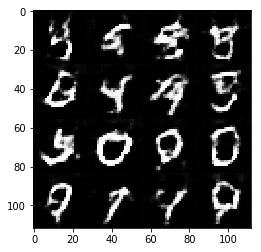

Epoch 1/2... Discriminator Loss: 1.5221... Generator Loss: 0.3273
Epoch 1/2... Discriminator Loss: 1.3538... Generator Loss: 1.4957
Epoch 1/2... Discriminator Loss: 1.1645... Generator Loss: 0.7111
Epoch 1/2... Discriminator Loss: 1.2076... Generator Loss: 0.6993
Epoch 1/2... Discriminator Loss: 1.2903... Generator Loss: 0.4304


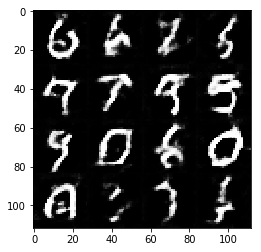

Epoch 1/2... Discriminator Loss: 1.1953... Generator Loss: 0.5550
Epoch 1/2... Discriminator Loss: 1.0967... Generator Loss: 0.7573
Epoch 1/2... Discriminator Loss: 1.0427... Generator Loss: 0.9770
Epoch 1/2... Discriminator Loss: 1.2397... Generator Loss: 1.4463
Epoch 1/2... Discriminator Loss: 1.2439... Generator Loss: 0.6356


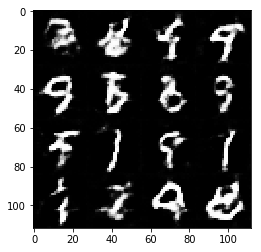

Epoch 1/2... Discriminator Loss: 1.0935... Generator Loss: 0.8429
Epoch 1/2... Discriminator Loss: 1.2159... Generator Loss: 1.1933
Epoch 1/2... Discriminator Loss: 1.1863... Generator Loss: 0.5959
Epoch 1/2... Discriminator Loss: 1.0391... Generator Loss: 1.0152
Epoch 1/2... Discriminator Loss: 1.2088... Generator Loss: 0.6721


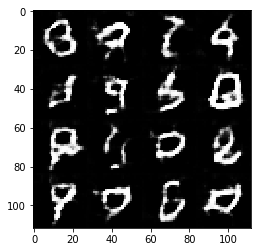

Epoch 1/2... Discriminator Loss: 1.0408... Generator Loss: 0.8599
Epoch 1/2... Discriminator Loss: 1.1338... Generator Loss: 0.6632
Epoch 1/2... Discriminator Loss: 1.0635... Generator Loss: 0.8363
Epoch 1/2... Discriminator Loss: 1.0335... Generator Loss: 0.7634
Epoch 1/2... Discriminator Loss: 1.2062... Generator Loss: 0.5410


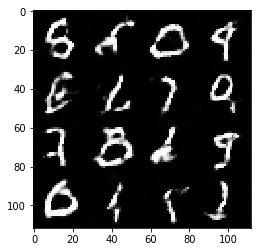

Epoch 1/2... Discriminator Loss: 1.2723... Generator Loss: 0.4745
Epoch 1/2... Discriminator Loss: 1.0421... Generator Loss: 1.1927
Epoch 1/2... Discriminator Loss: 1.1191... Generator Loss: 0.9377
Epoch 1/2... Discriminator Loss: 1.3693... Generator Loss: 1.3653
Epoch 1/2... Discriminator Loss: 1.0717... Generator Loss: 0.9209


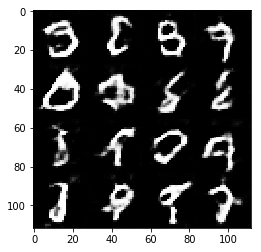

Epoch 1/2... Discriminator Loss: 1.2541... Generator Loss: 0.5345
Epoch 1/2... Discriminator Loss: 1.1435... Generator Loss: 1.2665
Epoch 1/2... Discriminator Loss: 1.1084... Generator Loss: 0.8237
Epoch 1/2... Discriminator Loss: 1.1535... Generator Loss: 0.9413
Epoch 1/2... Discriminator Loss: 1.1302... Generator Loss: 0.7616


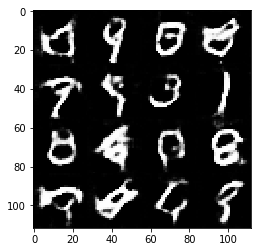

Epoch 1/2... Discriminator Loss: 1.1264... Generator Loss: 0.8181
Epoch 1/2... Discriminator Loss: 1.2276... Generator Loss: 0.4445
Epoch 1/2... Discriminator Loss: 1.1349... Generator Loss: 0.6689
Epoch 1/2... Discriminator Loss: 1.1409... Generator Loss: 1.0415
Epoch 1/2... Discriminator Loss: 1.0861... Generator Loss: 1.2023


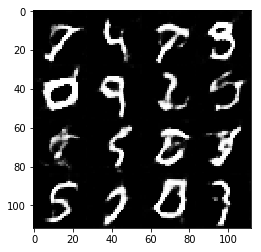

Epoch 1/2... Discriminator Loss: 1.3570... Generator Loss: 0.5335
Epoch 1/2... Discriminator Loss: 1.0050... Generator Loss: 0.9507
Epoch 1/2... Discriminator Loss: 1.0110... Generator Loss: 1.0713
Epoch 2/2... Discriminator Loss: 1.1046... Generator Loss: 0.6917
Epoch 2/2... Discriminator Loss: 1.0957... Generator Loss: 1.0126


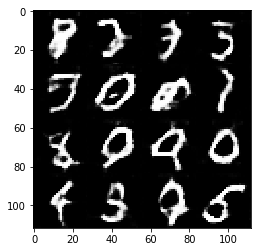

Epoch 2/2... Discriminator Loss: 1.2835... Generator Loss: 0.4792
Epoch 2/2... Discriminator Loss: 1.0033... Generator Loss: 0.8834
Epoch 2/2... Discriminator Loss: 0.9893... Generator Loss: 0.8548
Epoch 2/2... Discriminator Loss: 1.3137... Generator Loss: 0.4669
Epoch 2/2... Discriminator Loss: 1.1091... Generator Loss: 0.6673


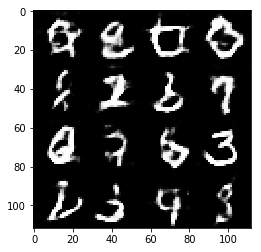

Epoch 2/2... Discriminator Loss: 1.0288... Generator Loss: 0.7694
Epoch 2/2... Discriminator Loss: 3.0950... Generator Loss: 0.0490
Epoch 2/2... Discriminator Loss: 1.1657... Generator Loss: 0.8589
Epoch 2/2... Discriminator Loss: 1.0987... Generator Loss: 0.6738
Epoch 2/2... Discriminator Loss: 0.9892... Generator Loss: 0.9055


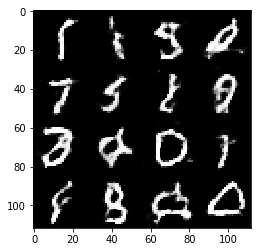

Epoch 2/2... Discriminator Loss: 1.0090... Generator Loss: 0.8642
Epoch 2/2... Discriminator Loss: 1.0729... Generator Loss: 0.9020
Epoch 2/2... Discriminator Loss: 1.0248... Generator Loss: 0.8848
Epoch 2/2... Discriminator Loss: 0.9672... Generator Loss: 0.7599
Epoch 2/2... Discriminator Loss: 1.0612... Generator Loss: 0.6641


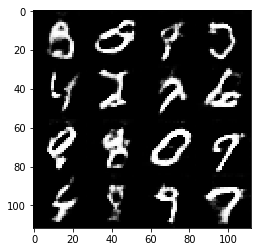

Epoch 2/2... Discriminator Loss: 0.8945... Generator Loss: 1.3477
Epoch 2/2... Discriminator Loss: 0.9515... Generator Loss: 0.8406
Epoch 2/2... Discriminator Loss: 0.9641... Generator Loss: 1.4078
Epoch 2/2... Discriminator Loss: 1.0448... Generator Loss: 0.6610
Epoch 2/2... Discriminator Loss: 1.0561... Generator Loss: 0.9021


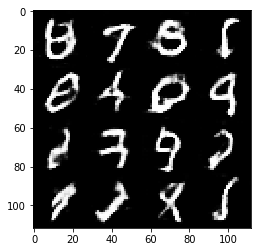

Epoch 2/2... Discriminator Loss: 0.9322... Generator Loss: 0.8590
Epoch 2/2... Discriminator Loss: 0.9410... Generator Loss: 1.0585
Epoch 2/2... Discriminator Loss: 0.8771... Generator Loss: 1.0188
Epoch 2/2... Discriminator Loss: 3.0540... Generator Loss: 0.0473
Epoch 2/2... Discriminator Loss: 0.8955... Generator Loss: 0.8323


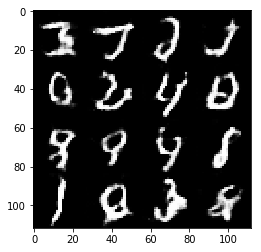

Epoch 2/2... Discriminator Loss: 0.8907... Generator Loss: 0.9747
Epoch 2/2... Discriminator Loss: 1.0505... Generator Loss: 0.7135
Epoch 2/2... Discriminator Loss: 1.0414... Generator Loss: 0.9255
Epoch 2/2... Discriminator Loss: 0.9439... Generator Loss: 1.1709
Epoch 2/2... Discriminator Loss: 1.0485... Generator Loss: 0.8402


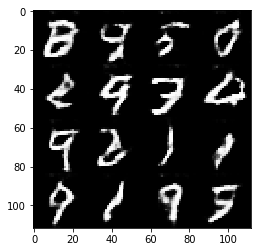

Epoch 2/2... Discriminator Loss: 0.9442... Generator Loss: 1.0557
Epoch 2/2... Discriminator Loss: 1.1926... Generator Loss: 0.5366
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.0707
Epoch 2/2... Discriminator Loss: 0.9557... Generator Loss: 1.7065
Epoch 2/2... Discriminator Loss: 1.0311... Generator Loss: 0.6791


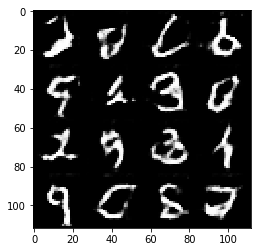

Epoch 2/2... Discriminator Loss: 1.0947... Generator Loss: 0.7761
Epoch 2/2... Discriminator Loss: 0.8972... Generator Loss: 1.0693
Epoch 2/2... Discriminator Loss: 1.2080... Generator Loss: 0.4606
Epoch 2/2... Discriminator Loss: 1.4040... Generator Loss: 0.4400
Epoch 2/2... Discriminator Loss: 1.8969... Generator Loss: 1.6080


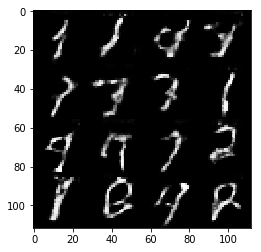

Epoch 2/2... Discriminator Loss: 1.1844... Generator Loss: 1.0913
Epoch 2/2... Discriminator Loss: 1.1747... Generator Loss: 0.8220
Epoch 2/2... Discriminator Loss: 1.1373... Generator Loss: 0.6341
Epoch 2/2... Discriminator Loss: 1.0062... Generator Loss: 0.8539
Epoch 2/2... Discriminator Loss: 0.8941... Generator Loss: 1.1626


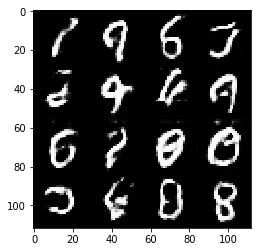

Epoch 2/2... Discriminator Loss: 0.9737... Generator Loss: 0.9504
Epoch 2/2... Discriminator Loss: 0.9448... Generator Loss: 1.0589
Epoch 2/2... Discriminator Loss: 0.9196... Generator Loss: 0.9004
Epoch 2/2... Discriminator Loss: 0.8827... Generator Loss: 1.0208
Epoch 2/2... Discriminator Loss: 0.9945... Generator Loss: 1.2196


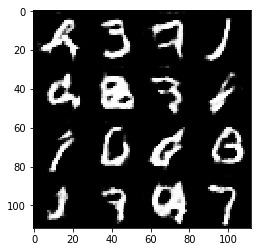

Epoch 2/2... Discriminator Loss: 0.8882... Generator Loss: 1.2369
Epoch 2/2... Discriminator Loss: 0.8932... Generator Loss: 1.0411
Epoch 2/2... Discriminator Loss: 0.9682... Generator Loss: 0.8960
Epoch 2/2... Discriminator Loss: 0.8487... Generator Loss: 0.9730
Epoch 2/2... Discriminator Loss: 0.8479... Generator Loss: 1.1336


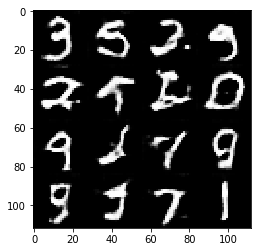

Epoch 2/2... Discriminator Loss: 1.2001... Generator Loss: 0.5885
Epoch 2/2... Discriminator Loss: 0.9084... Generator Loss: 1.1272
Epoch 2/2... Discriminator Loss: 0.8127... Generator Loss: 0.9725
Epoch 2/2... Discriminator Loss: 0.8988... Generator Loss: 0.7118
Epoch 2/2... Discriminator Loss: 0.8887... Generator Loss: 1.4353


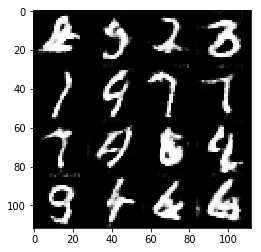

Epoch 2/2... Discriminator Loss: 0.9231... Generator Loss: 0.8909
Epoch 2/2... Discriminator Loss: 1.0679... Generator Loss: 1.1432
Epoch 2/2... Discriminator Loss: 1.1722... Generator Loss: 1.0394
Epoch 2/2... Discriminator Loss: 1.2131... Generator Loss: 0.7105
Epoch 2/2... Discriminator Loss: 0.9858... Generator Loss: 1.0695


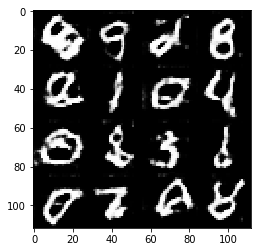

Epoch 2/2... Discriminator Loss: 0.9603... Generator Loss: 0.8565
Epoch 2/2... Discriminator Loss: 0.9876... Generator Loss: 0.9007
Epoch 2/2... Discriminator Loss: 0.8995... Generator Loss: 1.2221
Epoch 2/2... Discriminator Loss: 0.9156... Generator Loss: 0.9649
Epoch 2/2... Discriminator Loss: 0.9316... Generator Loss: 0.9246


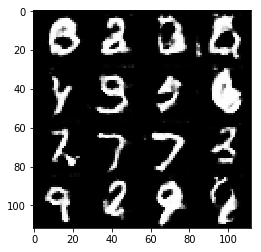

Epoch 2/2... Discriminator Loss: 0.8180... Generator Loss: 1.2689
Epoch 2/2... Discriminator Loss: 0.7433... Generator Loss: 1.2872
Epoch 2/2... Discriminator Loss: 0.8095... Generator Loss: 1.2412
Epoch 2/2... Discriminator Loss: 0.8892... Generator Loss: 1.3875
Epoch 2/2... Discriminator Loss: 0.8716... Generator Loss: 0.9307


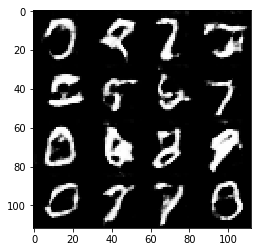

Epoch 2/2... Discriminator Loss: 0.7412... Generator Loss: 1.0857
Epoch 2/2... Discriminator Loss: 0.8189... Generator Loss: 1.2147
Epoch 2/2... Discriminator Loss: 0.9111... Generator Loss: 1.3098
Epoch 2/2... Discriminator Loss: 0.9042... Generator Loss: 1.2906
Epoch 2/2... Discriminator Loss: 1.4978... Generator Loss: 2.9414


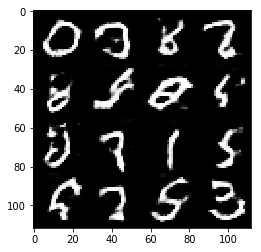

Epoch 2/2... Discriminator Loss: 0.8417... Generator Loss: 1.2908
Epoch 2/2... Discriminator Loss: 1.0713... Generator Loss: 0.7541
Epoch 2/2... Discriminator Loss: 0.8124... Generator Loss: 1.2199
Epoch 2/2... Discriminator Loss: 0.8466... Generator Loss: 1.0404
Epoch 2/2... Discriminator Loss: 0.8831... Generator Loss: 0.9143


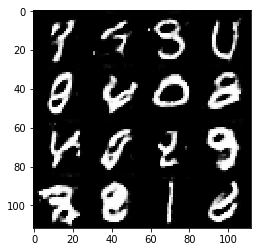

Epoch 2/2... Discriminator Loss: 1.0268... Generator Loss: 0.6248
Epoch 2/2... Discriminator Loss: 0.8656... Generator Loss: 1.1875
Epoch 2/2... Discriminator Loss: 0.9701... Generator Loss: 0.8478
Epoch 2/2... Discriminator Loss: 0.9591... Generator Loss: 0.8913
Epoch 2/2... Discriminator Loss: 0.9716... Generator Loss: 0.7873


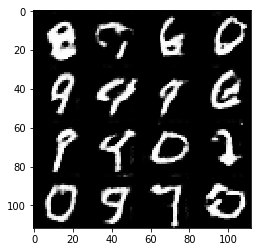

Epoch 2/2... Discriminator Loss: 0.8946... Generator Loss: 1.6148
Epoch 2/2... Discriminator Loss: 0.8169... Generator Loss: 1.3303


In [15]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 1.0202... Generator Loss: 1.1558
Epoch 1/1... Discriminator Loss: 0.9778... Generator Loss: 0.7002
Epoch 1/1... Discriminator Loss: 1.0340... Generator Loss: 0.7037
Epoch 1/1... Discriminator Loss: 1.0042... Generator Loss: 1.5187
Epoch 1/1... Discriminator Loss: 2.3447... Generator Loss: 0.1739


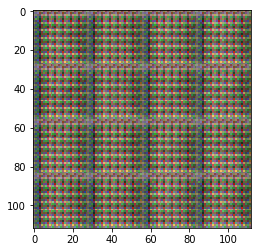

Epoch 1/1... Discriminator Loss: 1.0384... Generator Loss: 2.4741
Epoch 1/1... Discriminator Loss: 2.1601... Generator Loss: 0.2214
Epoch 1/1... Discriminator Loss: 1.3886... Generator Loss: 0.6768
Epoch 1/1... Discriminator Loss: 1.0982... Generator Loss: 0.9572
Epoch 1/1... Discriminator Loss: 1.0481... Generator Loss: 0.9522


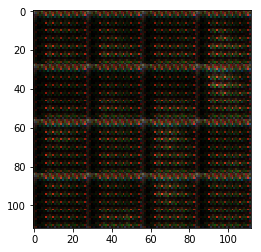

Epoch 1/1... Discriminator Loss: 0.9742... Generator Loss: 0.9582
Epoch 1/1... Discriminator Loss: 1.1661... Generator Loss: 1.0590
Epoch 1/1... Discriminator Loss: 0.9651... Generator Loss: 1.1782
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 1.5918
Epoch 1/1... Discriminator Loss: 1.0974... Generator Loss: 0.6662


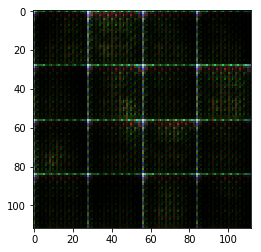

Epoch 1/1... Discriminator Loss: 1.3159... Generator Loss: 0.8248
Epoch 1/1... Discriminator Loss: 1.1138... Generator Loss: 0.6628
Epoch 1/1... Discriminator Loss: 1.0206... Generator Loss: 1.6743
Epoch 1/1... Discriminator Loss: 0.9505... Generator Loss: 1.6200
Epoch 1/1... Discriminator Loss: 1.1375... Generator Loss: 0.6896


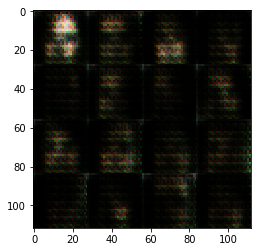

Epoch 1/1... Discriminator Loss: 1.0471... Generator Loss: 0.7615
Epoch 1/1... Discriminator Loss: 1.1330... Generator Loss: 0.7355
Epoch 1/1... Discriminator Loss: 0.9984... Generator Loss: 1.7252
Epoch 1/1... Discriminator Loss: 1.5291... Generator Loss: 0.4287
Epoch 1/1... Discriminator Loss: 1.1349... Generator Loss: 1.6962


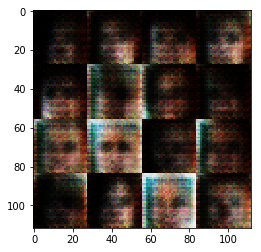

Epoch 1/1... Discriminator Loss: 1.0989... Generator Loss: 1.1991
Epoch 1/1... Discriminator Loss: 1.1296... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.0002... Generator Loss: 0.9738
Epoch 1/1... Discriminator Loss: 0.9866... Generator Loss: 1.2523
Epoch 1/1... Discriminator Loss: 0.9979... Generator Loss: 2.4154


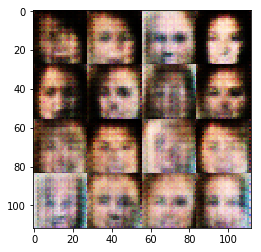

Epoch 1/1... Discriminator Loss: 0.9074... Generator Loss: 1.6089
Epoch 1/1... Discriminator Loss: 1.1471... Generator Loss: 1.5552
Epoch 1/1... Discriminator Loss: 1.0004... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.2664... Generator Loss: 2.8606
Epoch 1/1... Discriminator Loss: 0.9393... Generator Loss: 1.1904


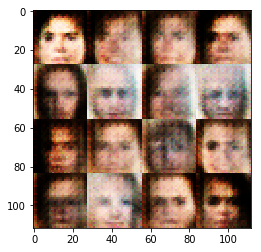

Epoch 1/1... Discriminator Loss: 0.9843... Generator Loss: 1.5069
Epoch 1/1... Discriminator Loss: 1.1106... Generator Loss: 0.6704
Epoch 1/1... Discriminator Loss: 1.0025... Generator Loss: 0.7382
Epoch 1/1... Discriminator Loss: 1.0001... Generator Loss: 1.9771
Epoch 1/1... Discriminator Loss: 1.0213... Generator Loss: 1.2184


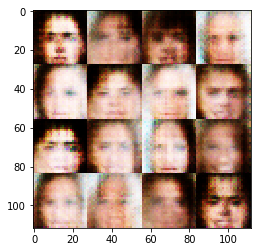

Epoch 1/1... Discriminator Loss: 1.0556... Generator Loss: 1.4921
Epoch 1/1... Discriminator Loss: 1.1716... Generator Loss: 1.3657
Epoch 1/1... Discriminator Loss: 1.0399... Generator Loss: 1.3537
Epoch 1/1... Discriminator Loss: 1.0079... Generator Loss: 1.1416
Epoch 1/1... Discriminator Loss: 0.9599... Generator Loss: 1.0134


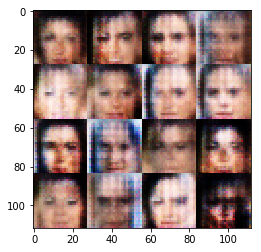

Epoch 1/1... Discriminator Loss: 1.3299... Generator Loss: 0.5279
Epoch 1/1... Discriminator Loss: 1.3647... Generator Loss: 0.5338
Epoch 1/1... Discriminator Loss: 0.9951... Generator Loss: 0.9584
Epoch 1/1... Discriminator Loss: 0.9430... Generator Loss: 1.2518
Epoch 1/1... Discriminator Loss: 1.0474... Generator Loss: 1.5125


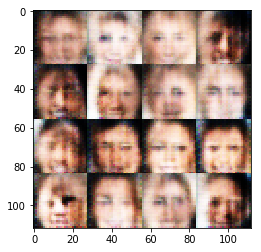

Epoch 1/1... Discriminator Loss: 0.9798... Generator Loss: 1.0470
Epoch 1/1... Discriminator Loss: 1.2659... Generator Loss: 0.5497
Epoch 1/1... Discriminator Loss: 0.9554... Generator Loss: 1.7908
Epoch 1/1... Discriminator Loss: 1.1278... Generator Loss: 0.8350
Epoch 1/1... Discriminator Loss: 1.5562... Generator Loss: 0.3315


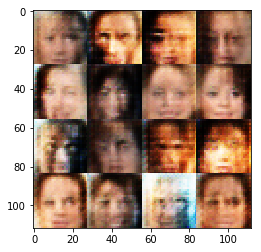

Epoch 1/1... Discriminator Loss: 1.1737... Generator Loss: 0.6275
Epoch 1/1... Discriminator Loss: 1.1184... Generator Loss: 0.7534
Epoch 1/1... Discriminator Loss: 1.4706... Generator Loss: 1.8281
Epoch 1/1... Discriminator Loss: 1.1894... Generator Loss: 0.6163
Epoch 1/1... Discriminator Loss: 1.0637... Generator Loss: 1.0210


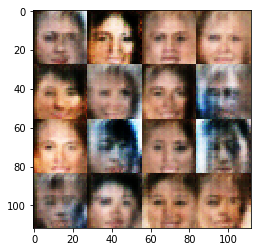

Epoch 1/1... Discriminator Loss: 1.0549... Generator Loss: 1.3055
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.4433
Epoch 1/1... Discriminator Loss: 1.0302... Generator Loss: 1.4855
Epoch 1/1... Discriminator Loss: 1.4156... Generator Loss: 0.5181
Epoch 1/1... Discriminator Loss: 1.2309... Generator Loss: 0.8548


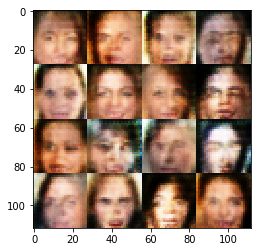

Epoch 1/1... Discriminator Loss: 1.2281... Generator Loss: 0.8257
Epoch 1/1... Discriminator Loss: 1.0091... Generator Loss: 0.9173
Epoch 1/1... Discriminator Loss: 1.1757... Generator Loss: 1.1568
Epoch 1/1... Discriminator Loss: 1.1975... Generator Loss: 1.4701
Epoch 1/1... Discriminator Loss: 1.2163... Generator Loss: 0.6425


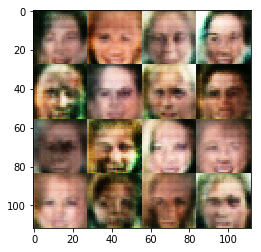

Epoch 1/1... Discriminator Loss: 1.1569... Generator Loss: 1.0560
Epoch 1/1... Discriminator Loss: 1.2233... Generator Loss: 0.6976
Epoch 1/1... Discriminator Loss: 1.1635... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.2298... Generator Loss: 0.7652
Epoch 1/1... Discriminator Loss: 1.2242... Generator Loss: 0.6759


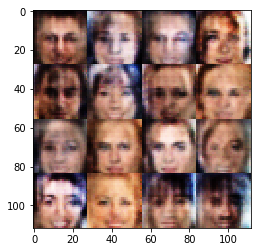

Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.4187
Epoch 1/1... Discriminator Loss: 1.1236... Generator Loss: 0.8398
Epoch 1/1... Discriminator Loss: 1.1751... Generator Loss: 0.6760
Epoch 1/1... Discriminator Loss: 1.2775... Generator Loss: 0.5699
Epoch 1/1... Discriminator Loss: 1.1927... Generator Loss: 1.1298


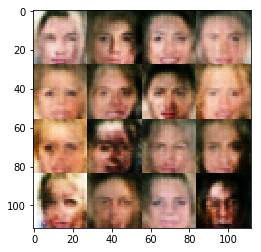

Epoch 1/1... Discriminator Loss: 1.0844... Generator Loss: 1.1569
Epoch 1/1... Discriminator Loss: 1.1883... Generator Loss: 0.7432
Epoch 1/1... Discriminator Loss: 1.3383... Generator Loss: 0.3682
Epoch 1/1... Discriminator Loss: 1.0925... Generator Loss: 0.6905
Epoch 1/1... Discriminator Loss: 1.1099... Generator Loss: 0.8701


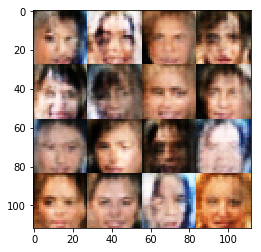

Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.4955
Epoch 1/1... Discriminator Loss: 1.2731... Generator Loss: 0.4945
Epoch 1/1... Discriminator Loss: 1.3001... Generator Loss: 0.7917
Epoch 1/1... Discriminator Loss: 1.1905... Generator Loss: 1.0656
Epoch 1/1... Discriminator Loss: 1.0865... Generator Loss: 0.7557


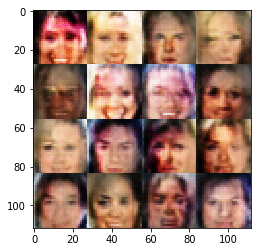

Epoch 1/1... Discriminator Loss: 1.4580... Generator Loss: 0.3890
Epoch 1/1... Discriminator Loss: 1.2934... Generator Loss: 0.6287
Epoch 1/1... Discriminator Loss: 1.3723... Generator Loss: 0.8134
Epoch 1/1... Discriminator Loss: 1.1346... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.1037... Generator Loss: 1.0075


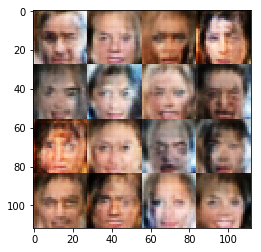

Epoch 1/1... Discriminator Loss: 1.3534... Generator Loss: 0.5563
Epoch 1/1... Discriminator Loss: 1.1885... Generator Loss: 0.8670
Epoch 1/1... Discriminator Loss: 1.2017... Generator Loss: 0.7483
Epoch 1/1... Discriminator Loss: 1.4823... Generator Loss: 0.5360
Epoch 1/1... Discriminator Loss: 1.0725... Generator Loss: 1.1456


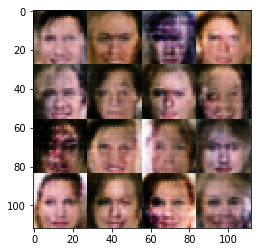

Epoch 1/1... Discriminator Loss: 1.1634... Generator Loss: 0.9341
Epoch 1/1... Discriminator Loss: 1.1283... Generator Loss: 0.8288
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 1.1585
Epoch 1/1... Discriminator Loss: 1.1747... Generator Loss: 1.1601
Epoch 1/1... Discriminator Loss: 1.1562... Generator Loss: 0.9169


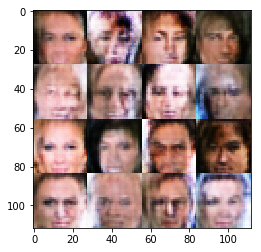

Epoch 1/1... Discriminator Loss: 1.2629... Generator Loss: 0.6458
Epoch 1/1... Discriminator Loss: 1.2905... Generator Loss: 0.7315
Epoch 1/1... Discriminator Loss: 1.1291... Generator Loss: 1.1455
Epoch 1/1... Discriminator Loss: 1.2808... Generator Loss: 0.8573
Epoch 1/1... Discriminator Loss: 1.0711... Generator Loss: 0.8766


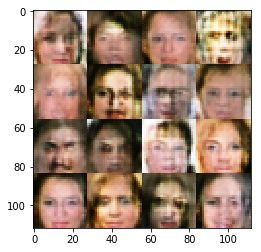

Epoch 1/1... Discriminator Loss: 1.1959... Generator Loss: 0.8268
Epoch 1/1... Discriminator Loss: 1.3301... Generator Loss: 0.5854
Epoch 1/1... Discriminator Loss: 1.0491... Generator Loss: 0.8647
Epoch 1/1... Discriminator Loss: 0.9364... Generator Loss: 1.1750
Epoch 1/1... Discriminator Loss: 1.0746... Generator Loss: 1.3586


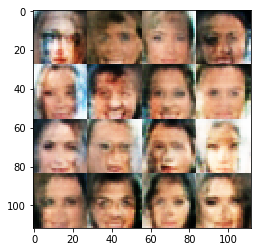

Epoch 1/1... Discriminator Loss: 1.1923... Generator Loss: 0.6877
Epoch 1/1... Discriminator Loss: 1.3955... Generator Loss: 1.4373
Epoch 1/1... Discriminator Loss: 1.1750... Generator Loss: 0.9362
Epoch 1/1... Discriminator Loss: 1.2440... Generator Loss: 0.9847
Epoch 1/1... Discriminator Loss: 1.1031... Generator Loss: 0.8563


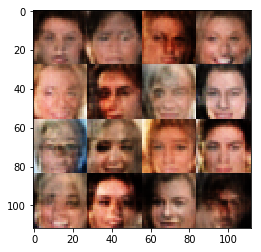

Epoch 1/1... Discriminator Loss: 1.1529... Generator Loss: 0.8780
Epoch 1/1... Discriminator Loss: 1.1077... Generator Loss: 0.9481
Epoch 1/1... Discriminator Loss: 1.0776... Generator Loss: 0.8211
Epoch 1/1... Discriminator Loss: 1.1336... Generator Loss: 0.7964
Epoch 1/1... Discriminator Loss: 1.1638... Generator Loss: 0.6341


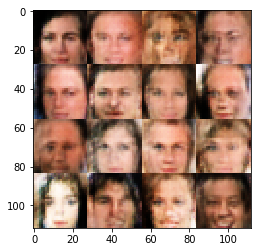

Epoch 1/1... Discriminator Loss: 1.1854... Generator Loss: 0.6417
Epoch 1/1... Discriminator Loss: 1.1724... Generator Loss: 0.9256
Epoch 1/1... Discriminator Loss: 1.0139... Generator Loss: 1.1231
Epoch 1/1... Discriminator Loss: 1.3411... Generator Loss: 0.4318
Epoch 1/1... Discriminator Loss: 1.2083... Generator Loss: 0.7256


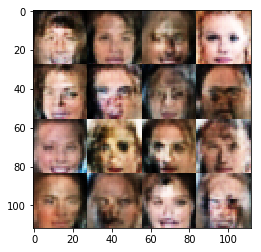

Epoch 1/1... Discriminator Loss: 1.2093... Generator Loss: 0.6808
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.2283... Generator Loss: 0.8187
Epoch 1/1... Discriminator Loss: 1.2847... Generator Loss: 0.6252
Epoch 1/1... Discriminator Loss: 1.0876... Generator Loss: 0.7499


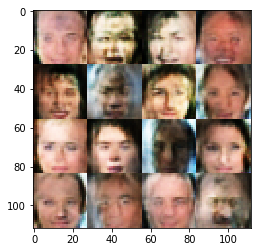

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 1.0471
Epoch 1/1... Discriminator Loss: 1.2576... Generator Loss: 0.8403
Epoch 1/1... Discriminator Loss: 1.1611... Generator Loss: 0.6605
Epoch 1/1... Discriminator Loss: 1.1907... Generator Loss: 1.0025
Epoch 1/1... Discriminator Loss: 1.0565... Generator Loss: 1.1580


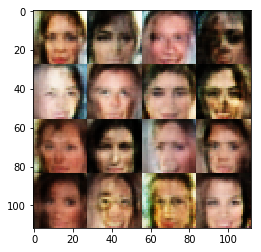

Epoch 1/1... Discriminator Loss: 1.1722... Generator Loss: 0.8974
Epoch 1/1... Discriminator Loss: 1.0804... Generator Loss: 0.9115
Epoch 1/1... Discriminator Loss: 1.2726... Generator Loss: 0.6541
Epoch 1/1... Discriminator Loss: 1.0553... Generator Loss: 0.9575
Epoch 1/1... Discriminator Loss: 1.3338... Generator Loss: 0.7365


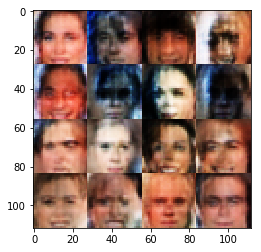

Epoch 1/1... Discriminator Loss: 1.2561... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.2119... Generator Loss: 0.9646
Epoch 1/1... Discriminator Loss: 1.1892... Generator Loss: 0.8843
Epoch 1/1... Discriminator Loss: 1.0994... Generator Loss: 0.9455
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.7676


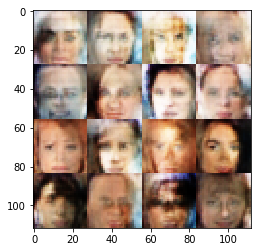

Epoch 1/1... Discriminator Loss: 1.2105... Generator Loss: 1.4684
Epoch 1/1... Discriminator Loss: 1.1658... Generator Loss: 0.6874
Epoch 1/1... Discriminator Loss: 1.2999... Generator Loss: 0.8581
Epoch 1/1... Discriminator Loss: 1.3798... Generator Loss: 0.3798
Epoch 1/1... Discriminator Loss: 1.1945... Generator Loss: 0.8278


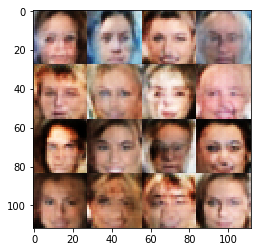

Epoch 1/1... Discriminator Loss: 1.1976... Generator Loss: 0.6841
Epoch 1/1... Discriminator Loss: 1.0992... Generator Loss: 0.7600
Epoch 1/1... Discriminator Loss: 1.0920... Generator Loss: 0.6959
Epoch 1/1... Discriminator Loss: 1.3349... Generator Loss: 1.3565
Epoch 1/1... Discriminator Loss: 1.1263... Generator Loss: 0.8126


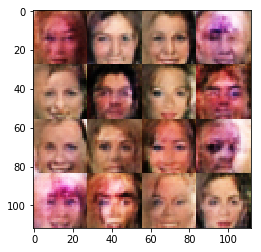

Epoch 1/1... Discriminator Loss: 1.1308... Generator Loss: 0.9589
Epoch 1/1... Discriminator Loss: 1.1206... Generator Loss: 0.9784
Epoch 1/1... Discriminator Loss: 1.0816... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1495... Generator Loss: 0.8294
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.4096


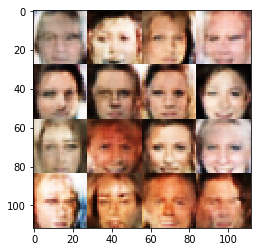

Epoch 1/1... Discriminator Loss: 1.1004... Generator Loss: 0.9682
Epoch 1/1... Discriminator Loss: 1.0373... Generator Loss: 1.0878
Epoch 1/1... Discriminator Loss: 1.2702... Generator Loss: 0.7909
Epoch 1/1... Discriminator Loss: 1.2424... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.2735... Generator Loss: 0.5255


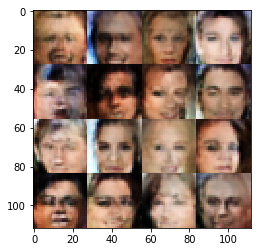

Epoch 1/1... Discriminator Loss: 1.1673... Generator Loss: 0.8267
Epoch 1/1... Discriminator Loss: 1.1290... Generator Loss: 0.8377
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.5474
Epoch 1/1... Discriminator Loss: 1.2204... Generator Loss: 1.0305
Epoch 1/1... Discriminator Loss: 1.3864... Generator Loss: 0.4365


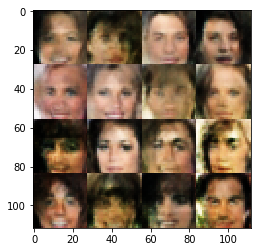

Epoch 1/1... Discriminator Loss: 1.2256... Generator Loss: 0.7628
Epoch 1/1... Discriminator Loss: 1.2439... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.3060... Generator Loss: 0.9771
Epoch 1/1... Discriminator Loss: 1.3275... Generator Loss: 0.9911
Epoch 1/1... Discriminator Loss: 1.2390... Generator Loss: 0.5352


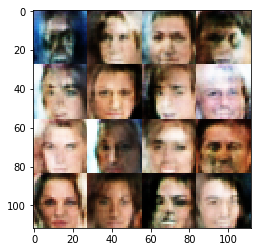

Epoch 1/1... Discriminator Loss: 1.2457... Generator Loss: 0.9816
Epoch 1/1... Discriminator Loss: 1.0860... Generator Loss: 1.0046
Epoch 1/1... Discriminator Loss: 1.1837... Generator Loss: 0.6821
Epoch 1/1... Discriminator Loss: 1.2612... Generator Loss: 0.5538
Epoch 1/1... Discriminator Loss: 0.9887... Generator Loss: 1.0254


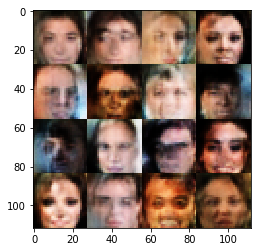

Epoch 1/1... Discriminator Loss: 1.3932... Generator Loss: 0.6205
Epoch 1/1... Discriminator Loss: 1.2252... Generator Loss: 1.6302
Epoch 1/1... Discriminator Loss: 1.2687... Generator Loss: 0.6488
Epoch 1/1... Discriminator Loss: 1.4629... Generator Loss: 0.4829
Epoch 1/1... Discriminator Loss: 1.1816... Generator Loss: 0.8486


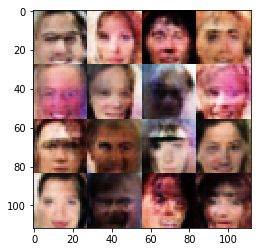

Epoch 1/1... Discriminator Loss: 1.2678... Generator Loss: 0.8156
Epoch 1/1... Discriminator Loss: 1.2070... Generator Loss: 0.7949
Epoch 1/1... Discriminator Loss: 1.1220... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.2365... Generator Loss: 0.8388
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 1.1479


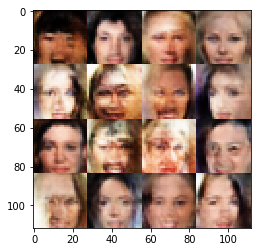

Epoch 1/1... Discriminator Loss: 1.2137... Generator Loss: 0.7118
Epoch 1/1... Discriminator Loss: 1.2264... Generator Loss: 0.6817
Epoch 1/1... Discriminator Loss: 1.1189... Generator Loss: 0.7757
Epoch 1/1... Discriminator Loss: 1.3719... Generator Loss: 0.4962
Epoch 1/1... Discriminator Loss: 1.2147... Generator Loss: 0.5971


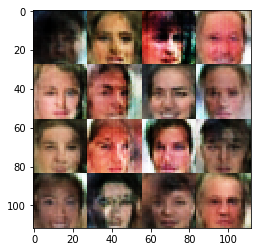

Epoch 1/1... Discriminator Loss: 1.1156... Generator Loss: 0.7807
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.6411
Epoch 1/1... Discriminator Loss: 1.1851... Generator Loss: 0.8380
Epoch 1/1... Discriminator Loss: 1.1083... Generator Loss: 1.0608
Epoch 1/1... Discriminator Loss: 1.1127... Generator Loss: 0.9865


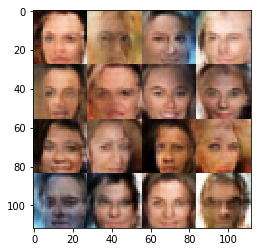

Epoch 1/1... Discriminator Loss: 1.1382... Generator Loss: 0.6640
Epoch 1/1... Discriminator Loss: 1.0717... Generator Loss: 0.8405
Epoch 1/1... Discriminator Loss: 1.1613... Generator Loss: 0.9537
Epoch 1/1... Discriminator Loss: 1.2312... Generator Loss: 0.7771
Epoch 1/1... Discriminator Loss: 1.0774... Generator Loss: 0.8978


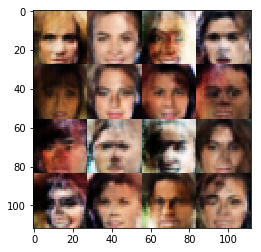

Epoch 1/1... Discriminator Loss: 1.2593... Generator Loss: 0.5605
Epoch 1/1... Discriminator Loss: 1.2166... Generator Loss: 0.6744
Epoch 1/1... Discriminator Loss: 0.9242... Generator Loss: 1.1046
Epoch 1/1... Discriminator Loss: 1.2509... Generator Loss: 0.7261
Epoch 1/1... Discriminator Loss: 1.2706... Generator Loss: 0.5634


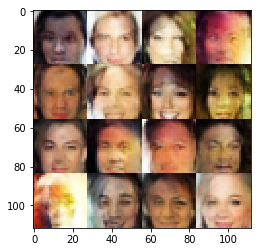

Epoch 1/1... Discriminator Loss: 1.2842... Generator Loss: 0.8183
Epoch 1/1... Discriminator Loss: 1.2686... Generator Loss: 0.8273
Epoch 1/1... Discriminator Loss: 1.2210... Generator Loss: 0.7131
Epoch 1/1... Discriminator Loss: 1.1228... Generator Loss: 0.9440
Epoch 1/1... Discriminator Loss: 1.0949... Generator Loss: 1.2270


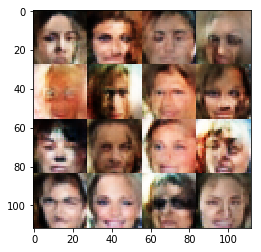

Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6614
Epoch 1/1... Discriminator Loss: 0.9544... Generator Loss: 0.9531
Epoch 1/1... Discriminator Loss: 1.4253... Generator Loss: 0.4737
Epoch 1/1... Discriminator Loss: 1.0573... Generator Loss: 0.7042
Epoch 1/1... Discriminator Loss: 1.1507... Generator Loss: 0.7303


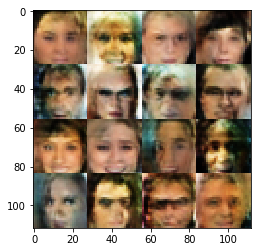

Epoch 1/1... Discriminator Loss: 1.4075... Generator Loss: 0.4776
Epoch 1/1... Discriminator Loss: 1.0566... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.1849... Generator Loss: 0.7468
Epoch 1/1... Discriminator Loss: 1.1689... Generator Loss: 0.9014
Epoch 1/1... Discriminator Loss: 1.3399... Generator Loss: 0.5124


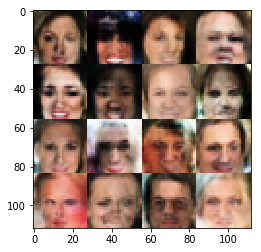

Epoch 1/1... Discriminator Loss: 1.2619... Generator Loss: 0.5049
Epoch 1/1... Discriminator Loss: 1.2566... Generator Loss: 0.6180
Epoch 1/1... Discriminator Loss: 1.1866... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.0320... Generator Loss: 0.7814
Epoch 1/1... Discriminator Loss: 1.1151... Generator Loss: 0.9418


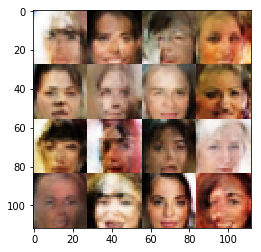

Epoch 1/1... Discriminator Loss: 1.2480... Generator Loss: 0.6654
Epoch 1/1... Discriminator Loss: 1.2165... Generator Loss: 0.7675
Epoch 1/1... Discriminator Loss: 1.0608... Generator Loss: 0.9118
Epoch 1/1... Discriminator Loss: 1.2874... Generator Loss: 0.9610
Epoch 1/1... Discriminator Loss: 1.3627... Generator Loss: 0.5100


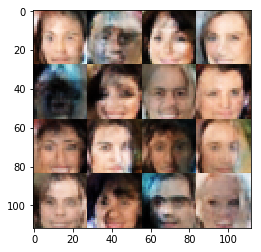

Epoch 1/1... Discriminator Loss: 1.4413... Generator Loss: 0.4228
Epoch 1/1... Discriminator Loss: 1.0889... Generator Loss: 0.8450
Epoch 1/1... Discriminator Loss: 1.2377... Generator Loss: 0.9038
Epoch 1/1... Discriminator Loss: 1.1864... Generator Loss: 0.6538
Epoch 1/1... Discriminator Loss: 1.1942... Generator Loss: 0.8424


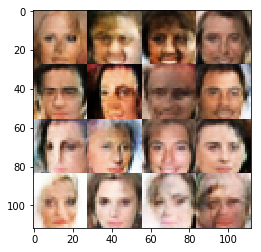

Epoch 1/1... Discriminator Loss: 1.2473... Generator Loss: 0.5266
Epoch 1/1... Discriminator Loss: 1.2388... Generator Loss: 0.6732
Epoch 1/1... Discriminator Loss: 1.2239... Generator Loss: 0.6007
Epoch 1/1... Discriminator Loss: 1.1252... Generator Loss: 0.6502
Epoch 1/1... Discriminator Loss: 1.1257... Generator Loss: 0.8496


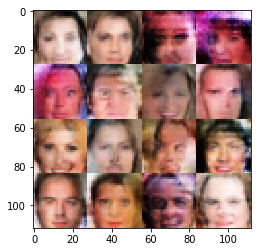

Epoch 1/1... Discriminator Loss: 1.0947... Generator Loss: 0.5765
Epoch 1/1... Discriminator Loss: 1.2237... Generator Loss: 0.9336
Epoch 1/1... Discriminator Loss: 1.2461... Generator Loss: 0.7527
Epoch 1/1... Discriminator Loss: 1.4796... Generator Loss: 0.4041
Epoch 1/1... Discriminator Loss: 1.0786... Generator Loss: 0.8677


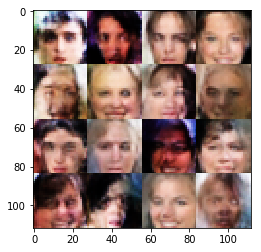

Epoch 1/1... Discriminator Loss: 1.1992... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.2740... Generator Loss: 0.5653
Epoch 1/1... Discriminator Loss: 0.9727... Generator Loss: 1.0368
Epoch 1/1... Discriminator Loss: 1.2354... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.2246... Generator Loss: 0.7322


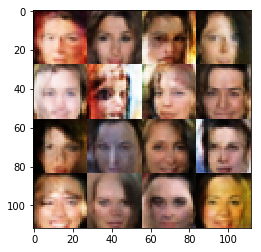

Epoch 1/1... Discriminator Loss: 1.2182... Generator Loss: 0.7905
Epoch 1/1... Discriminator Loss: 1.1235... Generator Loss: 0.8343
Epoch 1/1... Discriminator Loss: 1.1825... Generator Loss: 0.5861
Epoch 1/1... Discriminator Loss: 1.2192... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 0.7928


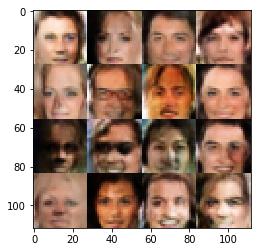

Epoch 1/1... Discriminator Loss: 1.2235... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.1420... Generator Loss: 0.8289
Epoch 1/1... Discriminator Loss: 1.1847... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.1215... Generator Loss: 0.7317
Epoch 1/1... Discriminator Loss: 1.3337... Generator Loss: 0.3960


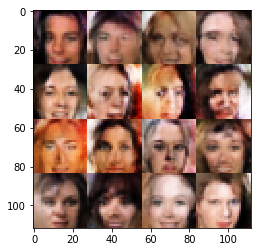

Epoch 1/1... Discriminator Loss: 1.0668... Generator Loss: 0.7722
Epoch 1/1... Discriminator Loss: 1.0067... Generator Loss: 1.1286
Epoch 1/1... Discriminator Loss: 1.2090... Generator Loss: 0.6336
Epoch 1/1... Discriminator Loss: 1.1342... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.2460... Generator Loss: 1.0729


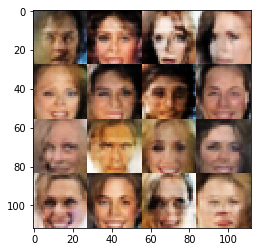

Epoch 1/1... Discriminator Loss: 1.4287... Generator Loss: 0.3669
Epoch 1/1... Discriminator Loss: 1.2695... Generator Loss: 0.8806
Epoch 1/1... Discriminator Loss: 1.0405... Generator Loss: 0.8799
Epoch 1/1... Discriminator Loss: 1.1109... Generator Loss: 0.9365
Epoch 1/1... Discriminator Loss: 1.2141... Generator Loss: 0.7145


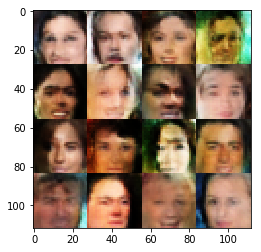

Epoch 1/1... Discriminator Loss: 1.1266... Generator Loss: 0.7569
Epoch 1/1... Discriminator Loss: 1.1811... Generator Loss: 1.0314
Epoch 1/1... Discriminator Loss: 1.1030... Generator Loss: 0.6920
Epoch 1/1... Discriminator Loss: 1.2456... Generator Loss: 0.6647
Epoch 1/1... Discriminator Loss: 1.2215... Generator Loss: 0.6415


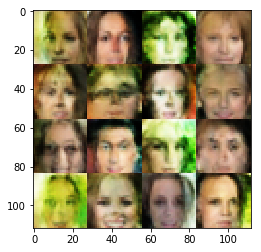

Epoch 1/1... Discriminator Loss: 1.2066... Generator Loss: 0.7657
Epoch 1/1... Discriminator Loss: 1.2748... Generator Loss: 0.6320
Epoch 1/1... Discriminator Loss: 0.9449... Generator Loss: 1.1153
Epoch 1/1... Discriminator Loss: 1.2543... Generator Loss: 0.9230
Epoch 1/1... Discriminator Loss: 1.1839... Generator Loss: 0.8673


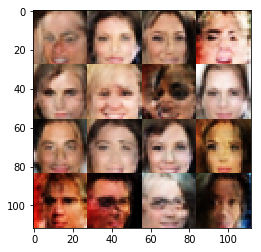

Epoch 1/1... Discriminator Loss: 1.1143... Generator Loss: 0.7013
Epoch 1/1... Discriminator Loss: 1.1769... Generator Loss: 1.1452
Epoch 1/1... Discriminator Loss: 1.1361... Generator Loss: 0.7154
Epoch 1/1... Discriminator Loss: 1.2920... Generator Loss: 0.5761
Epoch 1/1... Discriminator Loss: 1.0653... Generator Loss: 1.3538


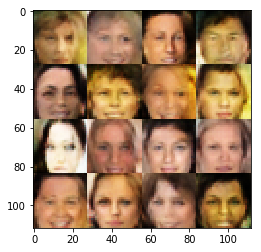

Epoch 1/1... Discriminator Loss: 1.1988... Generator Loss: 0.6982
Epoch 1/1... Discriminator Loss: 0.9935... Generator Loss: 1.0815
Epoch 1/1... Discriminator Loss: 1.3093... Generator Loss: 0.5787
Epoch 1/1... Discriminator Loss: 1.0506... Generator Loss: 1.0221
Epoch 1/1... Discriminator Loss: 1.0831... Generator Loss: 0.7791


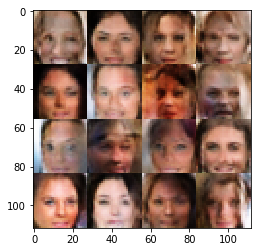

Epoch 1/1... Discriminator Loss: 1.0980... Generator Loss: 0.6526
Epoch 1/1... Discriminator Loss: 1.0563... Generator Loss: 1.4581
Epoch 1/1... Discriminator Loss: 1.3532... Generator Loss: 0.3485
Epoch 1/1... Discriminator Loss: 1.1306... Generator Loss: 0.8907
Epoch 1/1... Discriminator Loss: 1.0698... Generator Loss: 0.9101


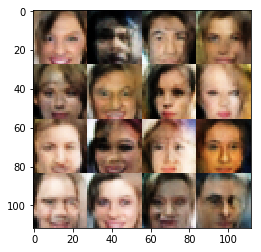

Epoch 1/1... Discriminator Loss: 1.2416... Generator Loss: 0.6460
Epoch 1/1... Discriminator Loss: 1.0178... Generator Loss: 1.0006
Epoch 1/1... Discriminator Loss: 1.0063... Generator Loss: 1.2309
Epoch 1/1... Discriminator Loss: 1.1434... Generator Loss: 0.9294
Epoch 1/1... Discriminator Loss: 1.3061... Generator Loss: 0.8120


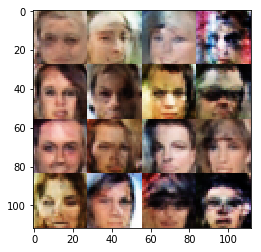

Epoch 1/1... Discriminator Loss: 1.1353... Generator Loss: 0.9334
Epoch 1/1... Discriminator Loss: 1.1607... Generator Loss: 0.7032
Epoch 1/1... Discriminator Loss: 1.1177... Generator Loss: 1.1122
Epoch 1/1... Discriminator Loss: 1.3031... Generator Loss: 0.4906
Epoch 1/1... Discriminator Loss: 1.1070... Generator Loss: 1.2172


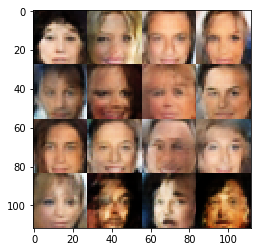

Epoch 1/1... Discriminator Loss: 0.9646... Generator Loss: 0.9211


In [16]:
batch_size = 64
z_dim = 100
learning_rate = 0.0002
beta1 = 0.5
tf.reset_default_graph()

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.